In [21]:
import numpy as np
import torch
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy, relu
import time
import copy
import scipy.stats


import matplotlib.pyplot as plt 
%matplotlib inline 

torch.manual_seed(0)
np.random.seed(1)

# 1. Edge Cases of AD

## Part 1.1: Discontinuous Functions
There are many correct solutions to this part. Here is one.

Define the function 
$$
    f(x) = 
    \begin{cases}
        x^2\, \text{ if } x \ge 0 \,, \\
        -1\, \text{ otherwise}.
    \end{cases}
$$
The function is discontinuous at zero, but it is right continuous, i.e., $\lim_{x \to 0^+} f(x) = f(0)$. 

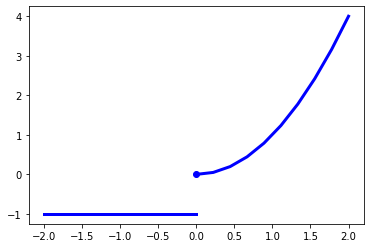

In [2]:
x1 = np.linspace(0, 2, 10)
plt.plot(x1, x1**2, linewidth=3, color='blue')
x2 = np.linspace(-2, -1e-6, 10)
plt.plot(x2, -1 * np.ones_like(x2), linewidth=3, color='blue')
plt.plot(0, 0, 'bo', linewidth=3) 

We compute the derivative at $x=0$ using PyTorch.

In [3]:
def my_function_1_1_a(x):
    if x >= 0:
        return x**2
    else:
        return torch.ones_like(x, requires_grad=True) * -1
    
x = torch.tensor(0.0, requires_grad=True)
out = my_function_1_1_a(x)
grad = torch.autograd.grad(outputs=out, inputs=[x])[0]
print('gradient =', grad)

gradient = tensor(0.)


Alternatively, we can define $f_1$ as 
$$
    f_1(x) = 
    \begin{cases}
        x^2\, \text{ if } x > 0 \,, \\
        -1728x\, \text{ if } x = 0 \,, \\
        -1\, \text{ otherwise}.
    \end{cases}
$$
Notice that at each point $x \in \mathbb{R}$, we have $f_1(x) = f(x)$.

In [4]:
def my_function_1_1_b(x):
    if x > 0:
        return x**2
    elif x == 0:
        return -1728*x
    else:
        return torch.ones_like(x, requires_grad=True) * -1
    
x = torch.tensor(0.0, requires_grad=True)
out = my_function_1_1_b(x)
grad = torch.autograd.grad(outputs=out, inputs=[x])[0]
print('gradient =', grad)

gradient = tensor(-1728.)


## Part 1.2

The idea is the same as previously. We define
$$
g_1(x) = x^2
$$
and 
$$ 
g_2(x) = 
\begin{cases} x^2\, \text{ if } x \neq 0 \,, \\ 
897x\, \text{ if } x = 0. \end{cases} 
$$

We leave it to you to verify the the output of torch.autograd at $0$ on this function.

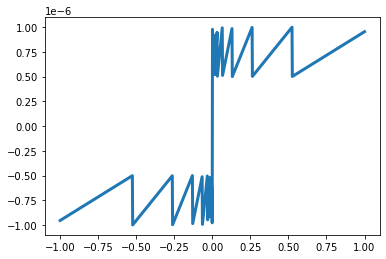

In [15]:
def my_loopy_function_1(x):
    while torch.abs(x) >= 1e-6:
        x = x/2
    return x

xs = torch.linspace(-1, 1, 1000)
ys = [my_loopy_function_1(x) for x in xs]
plt.plot(xs, ys, linewidth=3)

The derivatives are not defined at "kinks" or "elbows". This function is differently "almost everywhere".

In [16]:
def my_loopy_function_2(x):
    while torch.abs(x) > 1e-6:  # stopping criterion is different
        x = x/2
    return x

The difference in stopping criterion makes a difference at each of the kinks in the plot above. 
These are points of the form $2^n \times 10^{-6}$, where $n$ is any integer. Below, we use $n=1$.

In [17]:
x = torch.tensor(2e-6, requires_grad=True)  
y1 = my_loopy_function_1(x)
grad1 = torch.autograd.grad(outputs=y1, inputs=[x])[0]
y2 = my_loopy_function_2(x)
grad2 = torch.autograd.grad(outputs=y2, inputs=[x])[0]
print(grad1, grad2)

tensor(0.2500) tensor(0.5000)


This function is defined by 
$$
 \psi(x) = \frac{x}{2^{\lceil \log_2 (|x| \times 10^6) \rceil}} .
$$

This mathematical form is derived as follows:
Let $n$ be the smallest integer such that $|x|/ 2^n < 10^{-6}$. 
That is, $n$ should be the smallest integer such that 
$n > \log_2(x \times 10^6)$. The function value is simply $x / 2^n$ with this particular value of $n$.

## Part 1.4
This function is discontinuous at $x=0$. The derivatives returned by PyTorch are $0$ everywhere (check!).

We cannot use this function for gradient-based optimization because the gradient is zero wherever it is defined. SGD would make no progress at all since the gradient is always zero. 

There is a second problem that the function is discontinuous. Note that we require our functions to be continuous for deep learning to work.

For these two reasons, we use logistic regression. 

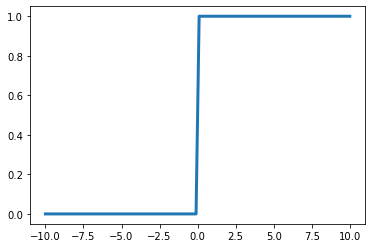

In [18]:
def zero_one_function(x):
    if x >= 0:
        return torch.ones_like(x, requires_grad=True)
    else:
        return torch.zeros_like(x, requires_grad=True)
    
xs = torch.linspace(-10, 10, 100)
ys = [zero_one_function(x) for x in xs]
plt.plot(xs, ys, linewidth=3)


# Part 2: Data augmentation

## Data + Utils

In [19]:
# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)  # flatten into a (n, d) shape
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)

n_class = np.unique(y_train).shape[0]

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


In [26]:
import torchvision.transforms as transforms

def transform_selected_data(X):
    # X is of shape (B, 784), where B is the batch_size
    X = X.view(-1, 28, 28)  # reshape to 28x28
    transform1 = transforms.RandomResizedCrop((28, 28), scale=(0.75, 1.0), ratio=(0.75, 1.33), interpolation=2)
    transform2 = transforms.RandomRotation((-10, 10))
    X_transformed = transform2(transform1(X))
    return X_transformed.view(-1, 784) # reshape into a vector

In [39]:
def compute_objective(model, X, y):
    """ Compute the multinomial logistic loss. 
        model is a module
        X of shape (n, d) and y of shape (n,)
    """
    # send 
    score = model(X)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return cross_entropy(input=score, target=y, reduction='mean') 

@torch.no_grad()
def compute_accuracy(model, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    is_train = model.training  # if True, model is in training mode
    model.eval()  # use eval mode for accuracy
    score = model(X)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    if is_train:  # switch back to train mode if appropriate
        model.train()
    return (predictions == y).sum() * 1.0 / y.shape[0]


@torch.no_grad()
def compute_accuracy_with_data_augmentation(model, X, y, T=8):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    is_train = model.training  # if True, model is in training mode
    model.eval()  # use eval mode for  accuracy
    all_predictions = []
    for t in range(T):
        X1 = transform_selected_data(X)
        score = model(X1)
        predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
        all_predictions.append(predictions)
    # make the final prediction using majority voting
    all_predictions = torch.stack(all_predictions).numpy()
    # Note: `combined_predictions` has to be a torch tensor for "==" to work in the last line of this function
    combined_predictions = torch.from_numpy(scipy.stats.mode(all_predictions, axis=0).mode.reshape(-1))
    
    if is_train:  # switch back to train mode if appropriate
        model.train()
    return (combined_predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(model, verbose=False):
    is_train = model.training  # if True, model is in training mode
    model.eval()  # switch to eval mode
    train_loss = compute_objective(model, X_train, y_train)
    test_loss = compute_objective(model, X_test, y_test)
    train_accuracy = compute_accuracy(model, X_train, y_train)
    train_accuracy_aug = compute_accuracy_with_data_augmentation(model, X_train, y_train)
    test_accuracy = compute_accuracy(model, X_test, y_test)
    test_accuracy_aug = compute_accuracy_with_data_augmentation(model, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f} {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f} {:.3f}').format(
                train_loss.item(), train_accuracy.item(), train_accuracy_aug.item(),
                test_loss.item(), test_accuracy.item(), test_accuracy_aug.item()
        )
    )
    if is_train:  # switch back to train mode if appropriate
        model.train()
    return (train_loss, train_accuracy, train_accuracy_aug, 
            test_loss, test_accuracy, test_accuracy_aug)

In [40]:
def minibatch_sgd_one_pass(model, X, y, learning_rate, batch_size, verbose=False, use_train_augmentation=False):
    model.train()
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        idxs = np.random.choice(X.shape[0], size=(batch_size,)) # draw `batch_size` many samples
        model.train()  # make sure we are in train mode
        # compute the objective.
        xs = X[idxs]
        if use_train_augmentation:  # apply data augmentation
            xs = transform_selected_data(xs)
        objective = compute_objective(model, xs, y[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=model.parameters())
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, g) in zip(model.parameters(), gradients):
                w -= learning_rate * g
    return model

In [41]:
class ConvNet(torch.nn.Module): # Hard-coded for 784 dimensional input, 10 outputs
    def __init__(self,num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.fc = torch.nn.Linear(7*7*32, 10)  
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        out = self.conv_ensemble_1(x)
        out = self.conv_ensemble_2(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out
    

In [42]:
model = ConvNet()


learning_rate = 0.04

logs = []
logs.append(compute_logs(model, verbose=True))

batch_size = 16

for _ in range(100):  
    model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, 
                                   batch_size=batch_size, verbose=False,
                                  use_train_augmentation=False)
    logs.append(compute_logs(model, verbose=True))

logs_noaug = np.asarray(logs)


Train Loss = 2.307, Train Accuracy = 0.069 0.065, Test Loss = 2.309, Test Accuracy = 0.069 0.064
Train Loss = 0.521, Train Accuracy = 0.819 0.765, Test Loss = 0.569, Test Accuracy = 0.798 0.760
Train Loss = 0.381, Train Accuracy = 0.865 0.771, Test Loss = 0.485, Test Accuracy = 0.838 0.797
Train Loss = 0.392, Train Accuracy = 0.860 0.821, Test Loss = 0.523, Test Accuracy = 0.819 0.782
Train Loss = 0.354, Train Accuracy = 0.876 0.815, Test Loss = 0.489, Test Accuracy = 0.838 0.784
Train Loss = 0.271, Train Accuracy = 0.908 0.832, Test Loss = 0.437, Test Accuracy = 0.856 0.838
Train Loss = 0.261, Train Accuracy = 0.912 0.865, Test Loss = 0.443, Test Accuracy = 0.854 0.802
Train Loss = 0.208, Train Accuracy = 0.926 0.863, Test Loss = 0.470, Test Accuracy = 0.862 0.837
Train Loss = 0.227, Train Accuracy = 0.917 0.857, Test Loss = 0.485, Test Accuracy = 0.851 0.807
Train Loss = 0.166, Train Accuracy = 0.944 0.873, Test Loss = 0.476, Test Accuracy = 0.868 0.836
Train Loss = 0.134, Train Accu

Train Loss = 0.000, Train Accuracy = 1.000 0.928, Test Loss = 1.119, Test Accuracy = 0.874 0.834
Train Loss = 0.000, Train Accuracy = 1.000 0.888, Test Loss = 1.121, Test Accuracy = 0.874 0.844
Train Loss = 0.000, Train Accuracy = 1.000 0.881, Test Loss = 1.123, Test Accuracy = 0.874 0.849
Train Loss = 0.000, Train Accuracy = 1.000 0.870, Test Loss = 1.124, Test Accuracy = 0.874 0.841
Train Loss = 0.000, Train Accuracy = 1.000 0.863, Test Loss = 1.125, Test Accuracy = 0.874 0.855
Train Loss = 0.000, Train Accuracy = 1.000 0.905, Test Loss = 1.127, Test Accuracy = 0.874 0.812
Train Loss = 0.000, Train Accuracy = 1.000 0.916, Test Loss = 1.130, Test Accuracy = 0.874 0.786
Train Loss = 0.000, Train Accuracy = 1.000 0.866, Test Loss = 1.133, Test Accuracy = 0.874 0.839
Train Loss = 0.000, Train Accuracy = 1.000 0.934, Test Loss = 1.131, Test Accuracy = 0.874 0.843
Train Loss = 0.000, Train Accuracy = 1.000 0.849, Test Loss = 1.134, Test Accuracy = 0.873 0.832
Train Loss = 0.000, Train Accu

In [43]:
model = ConvNet()


learning_rate = 0.04

logs = []
logs.append(compute_logs(model, verbose=True))

batch_size = 16

for _ in range(100):  # run multiple passes because our sub-sampled dataset is too small
    model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, 
                                   batch_size=batch_size, verbose=False,
                                  use_train_augmentation=True)
    logs.append(compute_logs(model, verbose=True))

logs_aug = np.asarray(logs)


Train Loss = 2.344, Train Accuracy = 0.110 0.124, Test Loss = 2.349, Test Accuracy = 0.116 0.121
Train Loss = 0.616, Train Accuracy = 0.780 0.759, Test Loss = 0.652, Test Accuracy = 0.763 0.748
Train Loss = 0.557, Train Accuracy = 0.800 0.792, Test Loss = 0.592, Test Accuracy = 0.790 0.786
Train Loss = 0.476, Train Accuracy = 0.823 0.809, Test Loss = 0.517, Test Accuracy = 0.809 0.801
Train Loss = 0.432, Train Accuracy = 0.841 0.832, Test Loss = 0.496, Test Accuracy = 0.826 0.812
Train Loss = 0.372, Train Accuracy = 0.865 0.834, Test Loss = 0.460, Test Accuracy = 0.843 0.839
Train Loss = 0.357, Train Accuracy = 0.869 0.850, Test Loss = 0.444, Test Accuracy = 0.846 0.831
Train Loss = 0.371, Train Accuracy = 0.862 0.843, Test Loss = 0.464, Test Accuracy = 0.845 0.824
Train Loss = 0.343, Train Accuracy = 0.876 0.850, Test Loss = 0.439, Test Accuracy = 0.850 0.838
Train Loss = 0.333, Train Accuracy = 0.879 0.865, Test Loss = 0.448, Test Accuracy = 0.853 0.839
Train Loss = 0.303, Train Accu

Train Loss = 0.160, Train Accuracy = 0.938 0.926, Test Loss = 0.498, Test Accuracy = 0.861 0.862
Train Loss = 0.147, Train Accuracy = 0.944 0.943, Test Loss = 0.447, Test Accuracy = 0.871 0.874
Train Loss = 0.142, Train Accuracy = 0.950 0.936, Test Loss = 0.480, Test Accuracy = 0.870 0.870
Train Loss = 0.144, Train Accuracy = 0.947 0.941, Test Loss = 0.462, Test Accuracy = 0.873 0.871
Train Loss = 0.150, Train Accuracy = 0.943 0.932, Test Loss = 0.471, Test Accuracy = 0.864 0.869
Train Loss = 0.138, Train Accuracy = 0.948 0.926, Test Loss = 0.481, Test Accuracy = 0.871 0.869
Train Loss = 0.129, Train Accuracy = 0.953 0.948, Test Loss = 0.463, Test Accuracy = 0.874 0.876
Train Loss = 0.155, Train Accuracy = 0.946 0.936, Test Loss = 0.486, Test Accuracy = 0.863 0.869
Train Loss = 0.161, Train Accuracy = 0.941 0.939, Test Loss = 0.522, Test Accuracy = 0.861 0.873
Train Loss = 0.135, Train Accuracy = 0.952 0.942, Test Loss = 0.485, Test Accuracy = 0.878 0.875
Train Loss = 0.168, Train Accu

Text(0.5, 1.0, 'Test Loss')

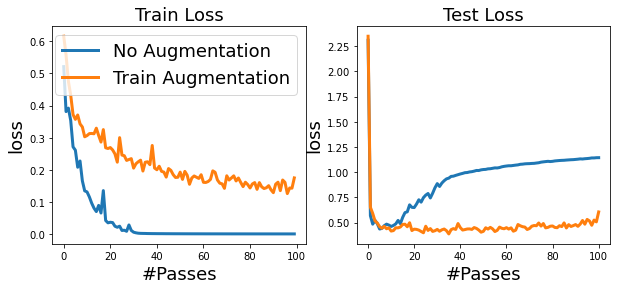

In [51]:
# Loss plots: Note that test augmentation does not impact train loss plots at all

f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(logs_noaug[1:, 0], linewidth=3, label="No Augmentation")
ax[1].plot(logs_noaug[0:, 3], linewidth=3)

ax[0].plot(logs_aug[1:, 0], linewidth=3, label="Train Augmentation")
ax[1].plot(logs_aug[0:, 3], linewidth=3)
ax[0].legend(fontsize=18)

for a in ax:
    a.set_xlabel('#Passes', fontsize=18)
    a.set_ylabel('loss', fontsize=18)
ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Test Loss', fontsize=18)


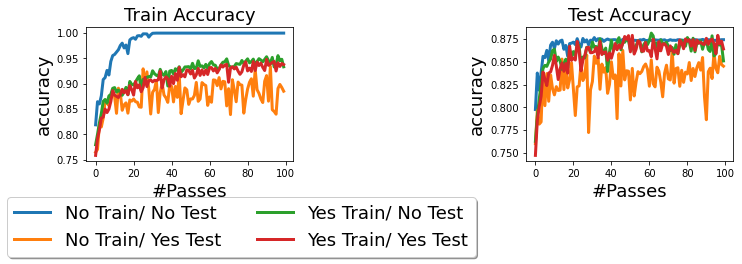

In [65]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(logs_noaug[1:, 1], linewidth=3, label="No Train/ No Test")
ax[0].plot(logs_noaug[1:, 2], linewidth=3, label="No Train/ Yes Test")
ax[1].plot(logs_noaug[1:, 4], linewidth=3)
ax[1].plot(logs_noaug[1:, 5], linewidth=3)

ax[0].plot(logs_aug[1:, 1], linewidth=3, label="Yes Train/ No Test")
ax[0].plot(logs_aug[1:, 2], linewidth=3, label="Yes Train/ Yes Test")
ax[1].plot(logs_aug[1:, 4], linewidth=3)
ax[1].plot(logs_aug[1:, 5], linewidth=3)
ax[0].legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.75, -0.2),
          fancybox=True, shadow=True, ncol=2)

for a in ax:
    a.set_xlabel('#Passes', fontsize=18)
    a.set_ylabel('accuracy', fontsize=18)
ax[0].set_title('Train Accuracy', fontsize=18)
ax[1].set_title('Test Accuracy', fontsize=18)

plt.tight_layout()

**NOTE**: The options with data augmentation during training require more training passes for convergence.

In this dataset, most images are centered. For real-world images, data augmentations lead to a substantial increase in accuracy.